# Avaliação de Modelos

In [64]:
# Importando as bibliotecas necessárias
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, f1_score

# Importação dos classificadores
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

In [65]:
# Carregar os dados gerados (merged_data.csv)
data = pd.read_csv("merged_data.csv")

In [66]:
# Seleciona apenas as colunas numéricas (incluindo as 21 features)
data = data.select_dtypes(include=[np.number])

In [67]:
# Excluir colunas indesejadas
colunas_excluir = [
    "open",
    "high",
    "low",
    "close",
    "volume",
    "variation",
    "vix_open",
    "vix_high",
    "vix_low",
    "vix_close",
    "vix_variation",
    "vix_mean",
]
data = data.drop(columns=colunas_excluir)

In [68]:
# Separar variáveis de entrada e saída
X = data.drop("indication", axis=1)
y = data["indication"]

In [69]:
# Dividir os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

A seguir iremos definir a função evaluate_model, que avalia o desempenho de um modelo treinado utilizando um conjunto de teste. Ela primeiro gera as previsões do modelo para os dados de teste com o método predict, e em seguida imprime a matriz de confusão, que mostra os acertos e erros do classificador, e o relatório de classificação, que detalha métricas como precisão, recall e f1-score para cada classe. Por fim, a função calcula e retorna o f1_score com média macro, que é a média do f1-score de todas as classes, garantindo uma avaliação equilibrada mesmo em casos de classes desbalanceadas.

In [70]:
# Função para avaliar o modelo (exibe a matriz de confusão, relatório e retorna o f1_macro)
def evaluate_model(model, X_test, y_test):
    predictions = model.predict(X_test)
    print("Matriz de Confusão:")
    print(confusion_matrix(y_test, predictions))
    print("\nRelatório de Classificação:")
    print(classification_report(y_test, predictions))
    return f1_score(y_test, predictions, average='macro')

In [71]:
# Dicionário com alguns classificadores e seus hiperparâmetros para busca em grade
modelos = {
    "LogisticRegression": {
        "model": LogisticRegression(max_iter=10000, solver="lbfgs"),
        "params": {
            "C": [0.1, 1, 10, 100],
            "class_weight": [None, "balanced"]
        }
    },
    "KNeighborsClassifier": {
        "model": KNeighborsClassifier(),
        "params": {
            "n_neighbors": [3, 5, 7, 9],
            "weights": ["uniform", "distance"]
        }
    },
    "DecisionTreeClassifier": {
        "model": DecisionTreeClassifier(),
        "params": {
            "max_depth": [None, 5, 10, 20],
            "min_samples_split": [2, 5, 10]
        }
    },
    "RandomForestClassifier": {
        "model": RandomForestClassifier(),
        "params": {
            "n_estimators": [100, 200],
            "max_depth": [None, 5, 10, 20],
            "min_samples_split": [2, 5, 10]
        }
    },
    "GradientBoostingClassifier": {
        "model": GradientBoostingClassifier(),
        "params": {
            "n_estimators": [100, 200],
            "learning_rate": [0.01, 0.1, 0.2],
            "max_depth": [3, 5, 7]
        }
    },
    "AdaBoostClassifier": {
        "model": AdaBoostClassifier(),
        "params": {
            "n_estimators": [50, 100, 200],
            "learning_rate": [0.01, 0.1, 1, 10]
        }
    },
    "SVC": {
        "model": SVC(),
        "params": {
            "C": [0.1, 1, 10, 100],
            "kernel": ["linear", "rbf"],
            "gamma": ["scale", "auto"]
        }
    },
    "GaussianNB": {
        "model": GaussianNB(),
        "params": {
            "var_smoothing": [1e-9, 1e-8, 1e-7]
        }
    },
    # "RedeNeural": {
    #     "model": MLPClassifier(max_iter=5000, random_state=42),
    #     "params": {
    #         "hidden_layer_sizes": [
    #             (50,), (100,), (200,), 
    #             (50,50), (100,50,25), (100,100,), (150,100,50)
    #         ],
    #         "activation": ["relu", "tanh", "logistic"],
    #         "alpha": [1e-5, 1e-4, 1e-3, 1e-2],
    #         "solver": ["adam", "sgd"],
    #         "learning_rate": ["constant", "adaptive"],
    #         "learning_rate_init": [0.001, 0.01, 0.1],
    #         "momentum": [0.9, 0.95]  # Só é considerado se o solver for 'sgd'
    #     }
    # },
}

Abaixo iremos definir a função test_all_models. Esta função realiza uma busca e avaliação de diversos modelos de classificação definidos em um dicionário. Para cada modelo, ela cria um pipeline que inclui um escalonamento padrão com o StandardScaler e o próprio classificador, definindo um espaço de hiperparâmetros (com prefixo "clf__") para serem otimizados via GridSearchCV. O GridSearchCV executa uma validação cruzada de 5 folds utilizando o f1_macro como métrica de desempenho, encontrando os melhores parâmetros para cada modelo.

Em seguida, a função coleta os resultados de cada modelo, armazenando a média da pontuação de validação cruzada (CV f1_macro), a pontuação no conjunto de teste (Teste f1_macro) e os melhores hiperparâmetros encontrados. Essa avaliação dupla permite comparar o desempenho do modelo tanto em dados vistos (durante a validação cruzada) quanto em dados novos (conjunto de teste), proporcionando uma visão mais completa da capacidade de generalização de cada modelo. Os resultados são organizados em um dicionário para facilitar a análise comparativa.

Por fim, a função identifica o modelo com a melhor performance baseada na métrica de validação cruzada e o avalia detalhadamente no conjunto de teste através de uma função auxiliar (evaluate_model), que exibe a matriz de confusão e o relatório de classificação. Adicionalmente, é gerado um gráfico de barras comparando as pontuações dos modelos no conjunto de validação e de teste, permitindo uma visualização rápida do desempenho relativo de cada abordagem. O melhor modelo e os resultados de todos os modelos são retornados para posterior análise ou uso em produção.

O **f1 score** é uma métrica que combina a precisão (quantos dos positivos previstos estão corretos) e o recall (quantos dos positivos reais foram identificados) em uma única medida, calculada como a média harmônica entre eles. Essa métrica é especialmente útil quando há um desbalanceamento entre as classes, pois ela penaliza fortemente valores baixos em precisão ou recall, fornecendo uma visão equilibrada do desempenho do modelo.

**CV f1_macro**: Média do f1 score calculado em várias partições (folds) dos dados de treinamento, que mostra como o modelo se comporta internamente durante a validação cruzada.

**Teste f1_macro**: f1 score calculado no conjunto de teste, que indica o desempenho do modelo em dados novos e não vistos durante o treinamento.

Treinando LogisticRegression...
CV f1_macro: 0.9083
Teste f1_macro: 0.9034
Melhores hiperparâmetros para LogisticRegression: {'clf__C': 100, 'clf__class_weight': 'balanced'}

Treinando KNeighborsClassifier...
CV f1_macro: 0.4929
Teste f1_macro: 0.5210
Melhores hiperparâmetros para KNeighborsClassifier: {'clf__n_neighbors': 5, 'clf__weights': 'uniform'}

Treinando DecisionTreeClassifier...
CV f1_macro: 0.5271
Teste f1_macro: 0.5192
Melhores hiperparâmetros para DecisionTreeClassifier: {'clf__max_depth': None, 'clf__min_samples_split': 2}

Treinando RandomForestClassifier...
CV f1_macro: 0.5016
Teste f1_macro: 0.5482
Melhores hiperparâmetros para RandomForestClassifier: {'clf__max_depth': 20, 'clf__min_samples_split': 10, 'clf__n_estimators': 200}

Treinando GradientBoostingClassifier...
CV f1_macro: 0.5889
Teste f1_macro: 0.6262
Melhores hiperparâmetros para GradientBoostingClassifier: {'clf__learning_rate': 0.2, 'clf__max_depth': 5, 'clf__n_estimators': 200}

Treinando AdaBoostClassifi

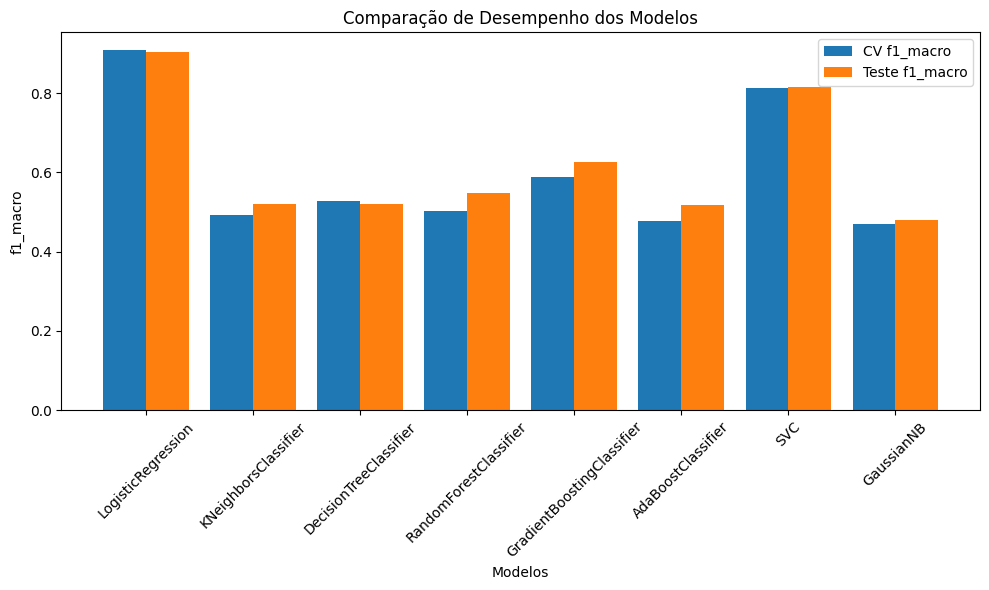

In [72]:
# Função que testa todos os modelos do dicionário usando GridSearchCV
def test_all_models(modelos, X_train, y_train, X_test, y_test):
    melhor_modelo_nome = None
    melhor_score = -np.inf
    melhor_modelo = None
    melhor_params = None
    resultados = {}

    for nome, info in modelos.items():
        print(f"Treinando {nome}...")
        # Cria pipeline com StandardScaler e o classificador
        pipeline = Pipeline([
            ("scaler", StandardScaler()),
            ("clf", info["model"])
        ])
        # Adiciona o prefixo 'clf__' aos hiperparâmetros para o GridSearchCV
        param_grid = {f"clf__{param}": valores for param, valores in info["params"].items()}
        
        grid = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1_macro', n_jobs=-1)
        grid.fit(X_train, y_train)
        
        # Coleta resultados do GridSearch
        best_params = grid.best_params_
        cv_score = grid.best_score_
        test_score = f1_score(y_test, grid.predict(X_test), average='macro')
        
        resultados[nome] = {
            "cv_score": cv_score,
            "test_score": test_score,
            "best_params": best_params,
            "best_estimator": grid.best_estimator_
        }
        
        print(f"CV f1_macro: {cv_score:.4f}")
        print(f"Teste f1_macro: {test_score:.4f}")
        print(f"Melhores hiperparâmetros para {nome}: {best_params}\n")
        
        # Verifica se esse modelo foi o melhor até o momento
        if cv_score > melhor_score:
            melhor_score = cv_score
            melhor_modelo_nome = nome
            melhor_modelo = grid.best_estimator_
            melhor_params = best_params

    print("=================================================")
    print(f"Melhor modelo: {melhor_modelo_nome}")
    print(f"CV f1_macro: {melhor_score:.4f}")
    print(f"Melhores hiperparâmetros: {melhor_params}")
    print("=================================================")
    
    print(f"Avaliação do melhor modelo ({melhor_modelo_nome}) no conjunto de teste:")
    evaluate_model(melhor_modelo, X_test, y_test)
    
    # Cria gráfico comparativo de desempenho entre CV e teste
    nomes_modelos = list(resultados.keys())
    cv_scores = [resultados[modelo]["cv_score"] for modelo in nomes_modelos]
    test_scores = [resultados[modelo]["test_score"] for modelo in nomes_modelos]
    
    x = range(len(nomes_modelos))
    plt.figure(figsize=(10, 6))
    plt.bar(x, cv_scores, width=0.4, label="CV f1_macro", align="center")
    plt.bar([i + 0.4 for i in x], test_scores, width=0.4, label="Teste f1_macro", align="center")
    plt.xticks([i + 0.2 for i in x], nomes_modelos, rotation=45)
    plt.xlabel("Modelos")
    plt.ylabel("f1_macro")
    plt.title("Comparação de Desempenho dos Modelos")
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    return melhor_modelo, resultados

# Executa a busca e avaliação de todos os modelos
melhor_modelo, resultados = test_all_models(modelos, X_train, y_train, X_test, y_test)


**LogisticRegression**:
- Obteve um CV f1_macro de 0.9083 e um Teste f1_macro de 0.9034, indicando alto desempenho e boa generalização.
- Os melhores hiperparâmetros encontrados foram {'clf__C': 100, 'clf__class_weight': 'balanced'}, sugerindo que uma forte regularização com ajuste de peso das classes foi ideal para esse modelo.

**Outros Modelos**:
- KNeighborsClassifier: Apresentou desempenho baixo com CV f1_macro de 0.4929 e Teste f1_macro de 0.5210, com os melhores hiperparâmetros sendo {'clf__n_neighbors': 5, 'clf__weights': 'uniform'}.
- DecisionTreeClassifier: Teve resultados medianos (CV f1_macro: 0.5271, Teste f1_macro: 0.5192), utilizando uma árvore sem limite de profundidade e split mínimo de 2.
- RandomForestClassifier: Mostrou desempenho um pouco melhor no teste (CV: 0.5016, Teste: 0.5482) com hiperparâmetros que controlam a profundidade (20), número de divisões (10) e 200 estimadores.
- GradientBoostingClassifier e AdaBoostClassifier: Exibiram desempenhos moderados, com GradientBoosting obtendo melhores números (CV: 0.5889, Teste: 0.6262) do que AdaBoost (CV: 0.4782, Teste: 0.5174).
- SVC: Demonstrou bom desempenho (CV: 0.8144, Teste: 0.8165) com hiperparâmetros otimizados para um kernel linear e regularização elevada.
- GaussianNB: Teve o desempenho mais baixo (CV: 0.4686, Teste: 0.4799), refletindo sua simplicidade em comparação com outros modelos.

**Melhor Modelo e Avaliação Final**:
- O melhor modelo identificado foi o LogisticRegression, com o mais alto CV f1_macro (0.9083).
- A avaliação final no conjunto de teste confirmou seu desempenho robusto, evidenciado por uma matriz de confusão e relatório de classificação que demonstram f1-scores em torno de 0.91 para ambas as classes, reforçando sua capacidade de generalização.

In [54]:
# Salvar o melhor modelo para uso na API
joblib.dump(melhor_modelo, "best_bitcoin_model.pkl")
print("Melhor modelo treinado e salvo como 'best_bitcoin_model.pkl'")

Melhor modelo treinado e salvo como 'best_bitcoin_model.pkl'
